# Analisis Preliminar Calidad Datos - Dataset Google

In [1]:
import os
os.environ["SPARK_HOME"] = r"F:\DataScience\spark\spark-3.5.3-bin-hadoop3\spark-3.5.3-bin-hadoop3"
os.environ["HADOOP_HOME"] = r"F:\DataScience\hadoop\hadoop-3.4.0"
os.environ["HADOOP_CONF_DIR"] = r"F:\DataScience\hadoop\hadoop-3.4.0\etc\hadoop"

import findspark
import pickle
import pandas as pd
import numpy as np

findspark.init()


# Asignación de recursos locales para SPARK.
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[10]")\
    .config("spark.executor.memory", "24g")\
    .config("spark.driver.memory", "6g")\
    .config("spark.sql.shuffle.partitions", "30")\
    .appName("PySpark").getOrCreate()

In [2]:
# Funciones de spark
from pyspark.sql import functions as F

In [3]:
# Funciones para graficar.
import seaborn as sns
import matplotlib.pyplot as plt

# Dataframe: metadata-sitios

In [ ]:
# Lectura de la carpeta metadata.
metadata_df = spark.read.json(r'F:\DataScience\PF - DataNova\datasets\Google Maps\metadata-sitios\*.json')

In [29]:
# Cargamos el dataset en cache.
metadata_df_cached = metadata_df.cache()

## Cantidad total de filas:

In [44]:
total_rows = metadata_df_cached.count()
total_rows

3025011

## Cantidad de columnas

In [32]:
print('Total columnas: ',len(metadata_df_cached.columns))
print(metadata_df_cached.columns)

Total columnas:  15
['MISC', 'address', 'avg_rating', 'category', 'description', 'gmap_id', 'hours', 'latitude', 'longitude', 'name', 'num_of_reviews', 'price', 'relative_results', 'state', 'url']


## Tipos de datos

In [ ]:
# Esquema
metadata_df_cached.printSchema()

root
 |-- MISC: struct (nullable = true)
 |    |-- Accessibility: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Activities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Amenities: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Atmosphere: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Crowd: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Dining options: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- From the business: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Getting here: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health & safety: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- Health and safety: array (nullable = true)


In [38]:
# Visualización.
metadata_df_cached.show(5, truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+----------+-------------------+-----------+-------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+------------+----------------+--------------+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------+----------------------------------------------------------------------------------------------------------------+
|MISC                                                                   

Observaciones:
- MISC: Struct : Estructura con diversas características del local. 
    - StrucType: Array : Cada structype es un array(lista) de strings.
- address: String :  Dirección del negocio
- avg_rating: Double : Score promedio del local
- category: Array : Lista de categorias asignadas al local.
- description: String : Descripcion de la localidad.
- gmap_id: String : Identificador del local dentro de google maps.
- hours: array : Lista de horarios en los cuales se encuentra abierto el local.
    - Formato: [dia, hora_inicio - hora_fin]
- latitude: double: Latitud geografica.
- longitude: double: Longitud geográfica.
- name: string: Denominación del local
- num_of_reviews: long: cantidad total de reviews.
- price: string: Parece ser el precio medio por persona que se gasta en el local.
- relative_results: array: lista de gmap_id's relacionados al local.
- state: string: Muestra el estado del local al recolectar la data. Estados como: abierto: cerrado: permanentemente cerrado.
- url: string: Url de googlemaps del sitio.

## Nulos

In [ ]:
# Vamos a calcular el porcentaje de nulos por columna:
null_counts = metadata_df_cached.select([F.round\
                                         (F.sum(F.col(c).isNull().cast("int"))/total_rows*100, 2).alias(c) \
                                            for c in metadata_df_cached.columns])
null_counts.show()

+-----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+
| MISC|address|avg_rating|category|description|gmap_id|hours|latitude|longitude|name|num_of_reviews|price|relative_results|state|url|
+-----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+
|22.84|   2.66|       0.0|    0.58|      91.59|    0.0|26.03|     0.0|      0.0| 0.0|           0.0| 90.9|            9.75|24.68|0.0|
+-----+-------+----------+--------+-----------+-------+-----+--------+---------+----+--------------+-----+----------------+-----+---+



Observaciones:
- Columnas con gran cantidad de nulos:
    - MISC. 22%
    - description 91%
    - hours 26%
    - price 90%
    - relative_results 10%
    - state 24%

## Duplicados

In [ ]:
# Visualizamos las entradas duplicadas en su totalidad (coincidencia exacta de todos los campos)
duplicates = metadata_df_cached.groupBy(metadata_df_cached.columns).count().filter("count > 1")

# Mostrar las filas duplicadas
duplicates.sort(F.asc('gmap_id')).show()

+--------------------+--------------------+----------+--------------------+-----------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+-----+
|                MISC|             address|avg_rating|            category|description|             gmap_id|               hours|          latitude|          longitude|                name|num_of_reviews|price|    relative_results|               state|                 url|count|
+--------------------+--------------------+----------+--------------------+-----------+--------------------+--------------------+------------------+-------------------+--------------------+--------------+-----+--------------------+--------------------+--------------------+-----+
|{NULL, NULL, NULL...|BB&T, 12220 Fairf...|       2.0|[Bank, Car financ...|       NULL|0x0:0x2df66ccfc30...|[[Wednesday, 9AM–...|        38.8660911|        -77.

In [ ]:
# Contamos : Un total de 26 573 duplicados.
duplicates.count()

26573

In [ ]:
# Duplicados de solo los IDs de gmap_id.
duplicated_ids = metadata_df_cached.select('gmap_id').groupBy('gmap_id').count().filter("count > 1")
duplicated_ids.show()

+--------------------+-----+
|             gmap_id|count|
+--------------------+-----+
|0x8084d0c62e26baa...|    2|
|0x864741ea3489d6c...|    2|
|0x88c33f1c8e1f99a...|    2|
|0x881614ed3a8e45a...|    2|
|0x89d0ba60af135b2...|    2|
|0x88f5a284e80502b...|    2|
|0x88f5a262358cae1...|    2|
|0x89c8b8ba089dbdc...|    2|
|0x89c8127d9fb00a8...|    2|
|0x88d9b373ab13888...|    2|
|0x88d9bb0ade90b1b...|    2|
|0x8814b742fa934f5...|    2|
|0x88315d25d1d7608...|    2|
|0x54afb44118f430d...|    2|
|0x8644cbd8a859939...|    2|
|0x87f07545743ecf4...|    2|
|0x88342edd9887e79...|    2|
|0x88c2c73fcb9cb85...|    2|
|0x80dcebb0f57d204...|    2|
|0x80c8c6a03032332...|    2|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Se trata de las mismas entradas.
duplicated_ids.count()

26573

In [52]:
# Porcentaje de duplicados:
duplicated_ids.count()/total_rows*100

0.8784430866532387

Tenemos un total de 26573 filas duplicadas, lo que representa el 0.87% del dataframe.

## Outliers

In [ ]:
# Transformamos el dataset a pandas para poder graficar
metadata_pd = metadata_df_cached.select("avg_rating",  "num_of_reviews").toPandas()

In [68]:
statistics_pd = metadata_pd.describe()
statistics_pd

,avg_rating,num_of_reviews
count,3.025011e+06,3.025011e+06
mean,4.303736e+00,4.362911e+01
std,7.127077e-01,1.429952e+02
min,1.000000e+00,1.000000e+00
25%,4.000000e+00,7.000000e+00
50%,4.500000e+00,1.700000e+01
75%,4.800000e+00,4.300000e+01
max,5.000000e+00,9.998000e+03


In [67]:
# Total de 131 978 537 reviews (132 millones)
total_reviews = metadata_pd['num_of_reviews'].sum()
total_reviews

131978537

In [60]:
metadata_pd

,avg_rating,num_of_reviews
0,4.9,16
1,4.5,6
2,4.4,18
3,3.3,6
4,4.3,7
...,...,...
3025006,4.0,424
3025007,3.1,268
3025008,4.5,194
3025009,3.7,24


<Axes: xlabel='avg_rating', ylabel='Count'>

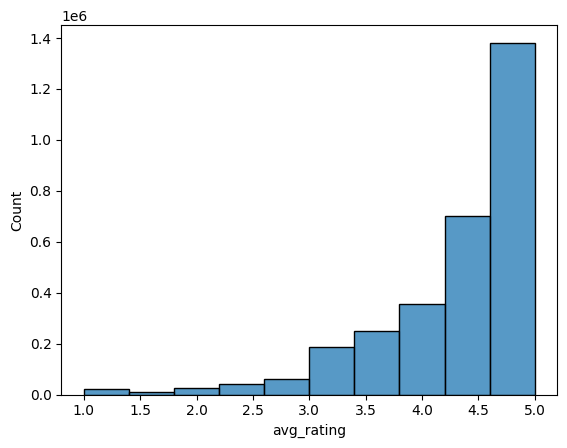

In [ ]:
# Visualizamos la distribución del rating en el dataset.
sns.histplot(data=metadata_pd, x='avg_rating', bins=10)

<Axes: xlabel='num_of_reviews', ylabel='Count'>

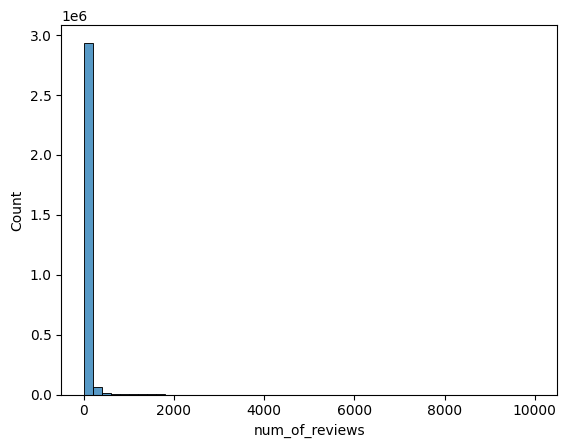

In [ ]:
# Visualizamos la distribución de total_reviews en el dataset.
sns.histplot(data=metadata_pd, x='num_of_reviews', bins=50)

### Outliers avg_rating

<Axes: xlabel='avg_rating'>

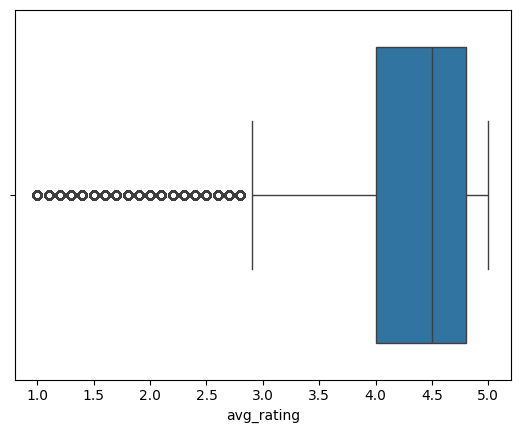

In [ ]:
sns.boxplot(data=metadata_pd, x='avg_rating')

In [ ]:
# Calculamos el IQR para luego filtrar valores outliers.
IQR = statistics_pd.loc['75%','avg_rating'] - statistics_pd.loc['25%','avg_rating']
min_value = statistics_pd.loc['25%','avg_rating'] - 1.5*IQR
min_value

2.8000000000000003

In [89]:
# Filtramos y obtenemos el total de datos outliers en la columna avg_rating
outliers_rating = metadata_pd[metadata_pd['avg_rating']<min_value]
total_outliers_reviews = outliers_rating['num_of_reviews'].sum()
outliers_count = outliers_rating.shape[0]
print('Total avg_rating outliers: ', outliers_count)
print('% stablishments: ', outliers_count / metadata_pd.shape[0] * 100, '%' )
print('Total reviews in outliers: ', total_outliers_reviews)
print('% of reviews in avg_rating outliers: ', total_outliers_reviews/total_reviews*100, '%')

Total avg_rating outliers:  137842
% stablishments:  4.556743760601202 %
Total reviews in outliers:  2962103
% of reviews in avg_rating outliers:  2.2443823574131603 %


### Outliers num_of_reviews

<Axes: xlabel='num_of_reviews'>

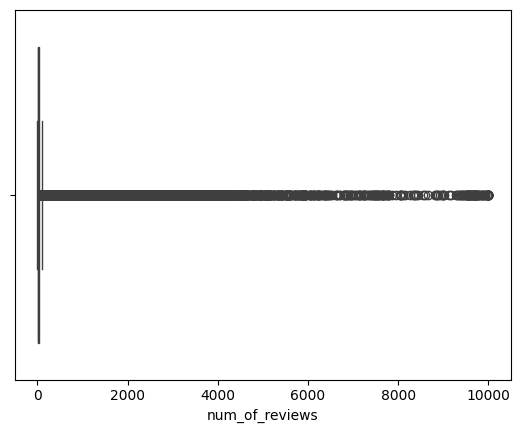

In [61]:
sns.boxplot(data=metadata_pd, x='num_of_reviews')

In [ ]:
IQR = statistics_pd.loc['75%', 'num_of_reviews'] - statistics_pd.loc['25%', 'num_of_reviews']
max_value = statistics_pd.loc['75%', 'num_of_reviews'] + 1.5*IQR
max_value

# Aparentemente lo normal es que los establecimientos tengo menos de 97 reviews

97.0

In [82]:
outliers_reviews = metadata_pd[metadata_pd['num_of_reviews']>97]
total_outliers_reviews = outliers_reviews.shape[0]
outliers_reviews_sum = outliers_reviews['num_of_reviews'].sum()

print('Total num_of_reviews outliers: ', total_outliers_reviews)
print('% stablishments: ', total_outliers_reviews / metadata_pd.shape[0] * 100, '%' )
print('Total reviews in outliers: ', outliers_reviews_sum)
print('% of reviews in avg_rating outliers: ', outliers_reviews_sum/total_reviews*100, '%')

Total num_of_reviews outliers:  284233
% stablishments:  9.396098063775636 %
Total reviews in outliers:  71590730
% of reviews in avg_rating outliers:  54.24422154338625 %


Observaciones:
- Tenemos outliers en la columna avg_rating, tratandose de lugares con muy bajo rating. Estos sitios con bajo rating representan el 5% de establecimiento y conglomeran el 2.2% del total de reviews.
- Respecto a los outliers en la columna num_of_reviews, contamos con un total de 284mil outliers, que poseen mas de 97 reviews. Estos establecimientos representan el 9.3% de todos los establecimientos, al parecer son establecimientos populares. A nivel de reviews, representan el 54% del total de los reviews en todo el dataset. 

# Dataframe reviews-estados

In [ ]:
# Liberamos el dataset previo del cache.
metadata_df_cached.unpersist()

DataFrame[MISC: struct<Accessibility:array<string>,Activities:array<string>,Amenities:array<string>,Atmosphere:array<string>,Crowd:array<string>,Dining options:array<string>,From the business:array<string>,Getting here:array<string>,Health & safety:array<string>,Health and safety:array<string>,Highlights:array<string>,Lodging options:array<string>,Offerings:array<string>,Payments:array<string>,Planning:array<string>,Popular for:array<string>,Recycling:array<string>,Service options:array<string>>, address: string, avg_rating: double, category: array<string>, description: string, gmap_id: string, hours: array<array<string>>, latitude: double, longitude: double, name: string, num_of_reviews: bigint, price: string, relative_results: array<string>, state: string, url: string]

In [4]:
reviews_df = spark.read.json(r'F:\DataScience\PF - DataNova\datasets\Google Maps\reviews-estados\**\*.json')

In [5]:
reviews_df_cached = reviews_df.cache()

In [102]:
reviews_df_cached.show(5, truncate=False)

+-------------------------------------+----------------+----+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+---------------------+
|gmap_id                              |name            |pics|rating|resp                                                                                                                                                                                                                            

## Cantidad filas y columnas

In [101]:
# Total Reviews
total_reviews = reviews_df_cached.count()
print('Total reviews: ', total_reviews)

Total reviews:  89946359


In [100]:
print("Cantidad de columnas: ", len(reviews_df_cached.columns))
reviews_df_cached.columns

Cantidad de columnas:  8


['gmap_id', 'name', 'pics', 'rating', 'resp', 'text', 'time', 'user_id']

## Tipos de datos

In [103]:
reviews_df_cached.printSchema()

root
 |-- gmap_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- pics: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- url: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |-- rating: long (nullable = true)
 |-- resp: struct (nullable = true)
 |    |-- text: string (nullable = true)
 |    |-- time: long (nullable = true)
 |-- text: string (nullable = true)
 |-- time: long (nullable = true)
 |-- user_id: string (nullable = true)



Observaciones:
- gmap_id: string: Id del establecimiento. Unico en gmap.
- name: string: Nombre del establecimiento.
- pics: array: Lista de urls de imagenes.
- rating: long: rating del 1 al 5. Podría representarse con un integer.
- resp: struct: respuesta del establecimiento, 
    - text: string: texto de respuesta
    - time: long: fecha de respuesta
- text: string: text del review.
- time: long: fecha del comentario. En formato long, es posible requiera que se cambie el formato.
- user_id: string: id del usuario que realiza el comentario.

## Nulos

In [105]:
null_counts = reviews_df_cached.select([F.round\
                                         (F.sum(F.col(c).isNull().cast("int"))/total_reviews*100, 2).alias(c) \
                                            for c in reviews_df_cached.columns])
null_counts.show()

+-------+----+-----+------+-----+----+----+-------+
|gmap_id|name| pics|rating| resp|text|time|user_id|
+-------+----+-----+------+-----+----+----+-------+
|    0.0| 0.0|97.23|   0.0|87.74|43.7| 0.0|    0.0|
+-------+----+-----+------+-----+----+----+-------+



Observaciones:
- El 97% de los reviews no tienen imagenes. Ademas, no vamos a realizar ninguna operacion sobre imagenes en este estudio, por lo cual, podríamos prescindir de la columna.
- El 87% de los reviews no cuentan con una respuesta del negocio. 
- text: el 43.7% de los reviews no cuentan con texto, solo una puntuacion. Estos reviews no podrian usarse para sentiment analysis.

## Duplicados

In [106]:
duplicates = reviews_df_cached.groupBy(reviews_df_cached.columns).count().filter("count > 1")

# Mostrar las filas duplicadas
duplicates_cached = duplicates.cache()
duplicates_cached.sort(F.asc('gmap_id')).show()

+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+-----+
|             gmap_id|                name|pics|rating|                resp|                text|         time|             user_id|count|
+--------------------+--------------------+----+------+--------------------+--------------------+-------------+--------------------+-----+
|0x0:0x9edcb14b0cf...|               Glenn|NULL|     1|{Absolutely a fal...|Terrible service....|1528759896087|10299142920017057...|    2|
|0x103bf4c1810a4b5...|       Dominia Frank|NULL|     5|                NULL|Been going here f...|1551850282463|10985741773741928...|    2|
|0x103bf4c1810a4b5...|        Janis Mathis|NULL|     5|                NULL|             Love it|1544175012772|10836693939501203...|    2|
|0x103bf4c1810a4b5...|        Edward Brown|NULL|     5|                NULL|        Love it here|1500180712509|10067677726894377...|    2|
|0x103bf4c1810a4b5...|     

In [108]:
total_duplicates = duplicates_cached.count()
print("Se encontraron: ", total_duplicates, " duplicados.")
print("Esta cantidad representa el ", total_duplicates/total_reviews*100, "% del total de reviews")

Se encontraron:  1386843  duplicados.
Esta cantidad representa el  1.5418556297537291 % del total de reviews


Observaciones:
Se encontraron 1386843 entradas duplicadas dentro del dataset, lo que representa el 1.54% del total de reviews.

In [110]:
duplicates_cached.unpersist()

DataFrame[gmap_id: string, name: string, pics: array<struct<url:array<string>>>, rating: bigint, resp: struct<text:string,time:bigint>, text: string, time: bigint, user_id: string, count: bigint]

## Outliers

Aqui la unica columna que nos podría interesar evaluar es la columna rating.

In [ ]:
reviews_df_cached.select('rating').describe().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|          89946359|
|   mean|4.3019362128932865|
| stddev|1.1007920513773455|
|    min|                 1|
|    max|                 5|
+-------+------------------+



In [12]:
# Vamos a calcular los valores atípicos basados en z-score.
mean= 4.3
stddev = 1.1

lower_bound = mean - 3 * stddev
upper_bound = mean + 3 * stddev

print('Limite inferior: ',lower_bound)
print('Limite superior: ',upper_bound)


Limite inferior:  0.9999999999999996
Limite superior:  7.6


In [13]:
agg_review_rating = reviews_df_cached.select('rating').groupBy('rating').count()

In [14]:
agg_review_rating.show()

+------+--------+
|rating|   count|
+------+--------+
|     5|55313177|
|     2| 2914929|
|     4|18690909|
|     3| 8378388|
|     1| 4648956|
+------+--------+



In [15]:
review_hist_data = agg_review_rating.toPandas()

<Axes: xlabel='rating', ylabel='count'>

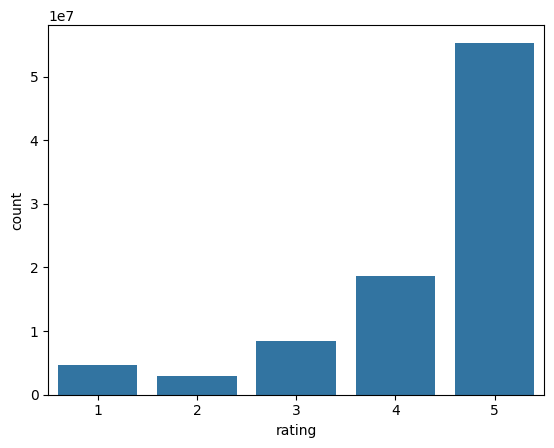

In [19]:
sns.barplot(data=review_hist_data.sort_values(by='rating'), x='rating', y='count')

No podemos decir que los valores 1 y 2 sean outliers, ya que se trata de una escala discreta acotada. Sin embargo, podemos concluir que los usuarios suelen dejar ratings bajos en menor medida.